<a href="https://colab.research.google.com/github/Freedyp/Cultural-Analytics/blob/main/12_5_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jon Chun
24 Oct 2021

# **Requirements**

* Must use **Chrome** browser (esp not Safari)
* Use only **plain text** files (no *.rtf, *.doc, etc)

# **Setup and Configuration**

In [ ]:
!pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 847 kB/s 
     |████████████████████████████████| 175 kB 15.7 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=0e21a2ed504d102a2b5e991aff848c0b77cdd58f4903e6f2bb55feefb4110cf9
  Stored in directory: /root/.cache/pip/wheels/5e/8c/80/c3646df8201ba6f5070297fe3779a4b70265d0bfd961c15302
Successfully built emoji


In [ ]:
!pip install unidecode  # clean-text dependency

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 7.9 MB/s 


In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110 kB 6.9 MB/s 
     |████████████████████████████████| 287 kB 43.5 MB/s 


In [ ]:
!pip install python-slugify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Python Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

from cleantext import clean
import contractions
from slugify import slugify

from scipy.signal import find_peaks

from google.colab import files



In [ ]:
# Setup matplotlib

# %matplotlib inline

plt.rcParams["figure.figsize"] = (20,10)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Globals

In [ ]:
# Global Vars

novel_filename_str = ''
novel_title_str = ''
novel_raw_str = ''
novel_clean_str = ''

novel_lines_ls = []
novel_sentences_ls = []
novel_paragraphs_ls = []

# Main (Modin) DataFrame for Novel Sentiments
sentiment_df = pd.DataFrame

TEXT_ENCODING = 'utf-8'

In [ ]:
def verify_novel(anovel_raw_str, anovel_title_str, index_ends=500):
  '''
  INPUT: string in some stage of processing
  OUTPUT: display summary index_ends chars of header/footer for verification
  '''

  print(f'Novel Title: {anovel_title_str}')
  print(f'  Char Len: {len(anovel_raw_str)}')
  print('====================================\n')
  print(f'Beginning:\n\n {anovel_raw_str[:index_ends]}\n\n')
  print('\n------------------------------------')
  print(f'Ending:\n\n {anovel_raw_str[-index_ends:]}\n\n')

In [ ]:
def save_text2txt_and_download(text_obj, file_suffix='_save.txt'):
  '''
  INPUT: text object and suffix to add to output text filename
  OUTPUT: Write text object to text file (both temp VM and download)
  '''

  if type(text_obj) == str:
    print('STEP 1. Processing String Object\n')
    str_obj = text_obj
  elif type(text_obj) == list:
    if (len(text_obj) > 0):
      if type(text_obj[0]) == str:
        print('STEP 1. Processing List of Strings Object\n')
        str_obj = "\n".join(text_obj)
      else:
        print('ERROR: Object is not an List of Strings [save_text2txt_and_download()]')
        return -1
    else:
      print('ERROR: Object is an empty List [save_text2txt_and_download()]')
      return -1
  else:
    print('ERROR: Object Type is neither String nor List [save_text2txt_and_download()]')
    return -1

  datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  # out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
  out_filename = novel_name_str.split('.')[0] + file_suffix

  # Write file to temporary VM filesystem
  print(f'STEP 2. Saving textfile to temporary VM file: {out_filename}\n')
  with open(out_filename, "w") as fp:
    fp.write(str_obj)

  # Download permanent copy of file
  print(f'STEP 3. Downloading permanent copy of textfile: {out_filename}\n')
  files.download(out_filename)

In [ ]:
def save_df2csv_and_download(df_obj, file_suffix='_save.csv', nodate=True):
  '''
  INPUT: DataFrame object and suffix to add to output csv filename
  OUTPUT: Write DataFrame object to csv file (both temp VM and download)
  '''

  if isinstance(df_obj, pd.DataFrame):
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
      out_filename = novel_name_str.split('.')[0] + file_suffix
    else:
      out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
    # print(f'STEP 1. Saving DataFrame: {df_obj.__name__} to temporary VM file: {out_filename}\n') # Also, isinstance(obj, pd.DataFrame)
    print(f'STEP 1. Saving DataFrame to temporary VM file: {out_filename}\n')
    df_obj.to_csv(out_filename, index=False) 
  else:
    print(f'ERROR: Object is not a DataFrame [save_df2csv_and_download()]')
    return -1

  # Download permanent copy of file
  print(f'STEP 2. Downloading permanent copy of csvfile: {out_filename}\n')
  files.download(out_filename)


# Test

# save_df2csv_and_download(temp_df, '_bert-nlptown.txt')

In [ ]:
def expand_contractions(input_str):
  '''
  INPUT: long string
  OUTPUT: long string with expanded contractions
  '''

  output_str = contractions.fix(input_str)

  return output_str

"""
# novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_ls]
novel_clean_ls = [contractions.fix(x) for x in novel_ls]
novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_clean_ls]
novel_clean_ls = [x.strip() for x in novel_clean_ls if len(x.strip()) > 1]
# novel_clean_ls = [re.sub(r"^[\"\']", "", x) for x in novel_clean_ls]  # re.sub("[\"\']", "", s)
# novel_clean_ls = [re.sub(r"[\"\']$", "", x) for x in novel_clean_ls]
novel_clean_ls = [x.encode('ascii',errors='ignore').decode() for x in novel_clean_ls]
# novel_bin = novel_clean_str.encode('ascii',errors='ignore')
# novel_clean_str = novel_bin.decode()

[f'[{x}]' for x in novel_clean_ls]
"""

'\n# novel_clean_ls = [re.sub(r\'[\n]+\', \' \', x).strip() for x in novel_ls]\nnovel_clean_ls = [contractions.fix(x) for x in novel_ls]\nnovel_clean_ls = [re.sub(r\'[\n]+\', \' \', x).strip() for x in novel_clean_ls]\nnovel_clean_ls = [x.strip() for x in novel_clean_ls if len(x.strip()) > 1]\n# novel_clean_ls = [re.sub(r"^["\']", "", x) for x in novel_clean_ls]  # re.sub("["\']", "", s)\n# novel_clean_ls = [re.sub(r"["\']$", "", x) for x in novel_clean_ls]\nnovel_clean_ls = [x.encode(\'ascii\',errors=\'ignore\').decode() for x in novel_clean_ls]\n# novel_bin = novel_clean_str.encode(\'ascii\',errors=\'ignore\')\n# novel_clean_str = novel_bin.decode()\n\n[f\'[{x}]\' for x in novel_clean_ls]\n'

# **Get the Novel Text**

## OPTION (a): Upload Raw Textfile

In [ ]:
%%time

# NOTE: 1m07s

# Upload Plain Text File
uploaded = files.upload()

# NOTE: Allows for multiple file uploads, will only process the last
#       Left in for future feature addition (processing multiple files at once)
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  novel_filename_str = fn

# Extract from Dict and decode binary into char string
novel_raw_str = uploaded[novel_filename_str].decode(TEXT_ENCODING)

Saving prideandprejudice_janeausten.txt to prideandprejudice_janeausten.txt
User uploaded file "prideandprejudice_janeausten.txt" with length 168601 bytes
CPU times: user 416 ms, sys: 44.6 ms, total: 461 ms
Wall time: 27.5 s


In [ ]:
#@title Enter Novel_Title in the form [Title] by [Author]

Novel_Title = "Pride and Prejudice by Jane Austen" #@param {type:"string"}

# Remove illegal filename punctuation
Novel_Title = Novel_Title.replace("'","")
Novel_Title = Novel_Title.replace('"','')
Novel_Title = Novel_Title.replace('.',' ')

novel_title_str = ' '.join([x.capitalize() for x in slugify(Novel_Title).replace('-',' ').split()])
novel_title_str

'Pride And Prejudice By Jane Austen'

In [ ]:
# CHECK: That you've trimmed the header/footer before uploading

print(f'Novel Filename:\n\n  {novel_filename_str}\n\n')

verify_novel(novel_raw_str, novel_title_str)

Novel Filename:

  prideandprejudice_janeausten.txt


Novel Title: Pride And Prejudice By Jane Austen
  Char Len: 168601

Beginning:

 Chapter I



Mr. Jones, of the Manor Farm, had locked the hen-houses for the night, but
was too drunk to remember to shut the pop-holes. With the ring of light
from his lantern dancing from side to side, he lurched across the yard,
kicked off his boots at the back door, drew himself a last glass of beer
from the barrel in the scullery, and made his way up to bed, where
Mrs. Jones was already snoring.

As soon as the light in the bedroom went out there was a stirring and a
fluttering all through 



------------------------------------
Ending:

 gs, bangings on the table, sharp suspicious glances, furious
denials. The source of the trouble appeared to be that Napoleon and
Mr. Pilkington had each played an ace of spades simultaneously.

Twelve voices were shouting in anger, and they were all alike. No question,
now, what had happened to the faces of the p

## OPTION (b): Read from gDrive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive

MessageError: ignored

In [ ]:
# drive.mount("/gdrive", force_remount=True)

In [ ]:
# CUSTOMIZE: set GDrive path below

%cd ./MyDrive/courses/2021f_iphs200_programming_humanity/code/

In [ ]:
!ls *.txt

In [ ]:
# CUSOTMIZE: set 'novel_filename' to the filename of your novel

# novel_filename = 'jkrowling_1sorcerersstone.txt'
novel_filename_str ='Percy_Jackson_The_Lightning_Thief.txt'

In [ ]:
#@title Enter Novel_Title in the form [Title] by [Author]

Novel_Title = "The Lightening Thief by Percy Jackson" #@param {type:"string"}
novel_title_str = Novel_Title

In [ ]:
# Read file into string

with open(novel_filename_str, "r") as fp:
  novel_raw_str = fp.read() #reading all the content in one step

In [ ]:
# Verify

# CHECK: That you've trimmed the header/footer before uploading

print(f'Novel Filename:\n\n  {novel_filename_str}\n\n')

verify_novel(novel_raw_str, novel_title_str)

In [ ]:
# END

In [ ]:
# Read novel into list of Paragraphs

delimiter = "\n\n"

with open(novel_filename, "r") as fp:
  novel_raw_str = fp.read() #reading all the content in one step
  #using the string methods we split it
  novel_parags_ls = novel_raw_str.split(delimiter)
  novel_parags_ls = [x.strip() for x in novel_parags_ls if len(x.strip()) > 2]

print(f'Paragraph Count: {len(novel_parags_ls)}')

In [ ]:
# Read novel into list of Lines

# may need delimiter

with open(novel_filename, 'r') as fp:
  novel_lines_ls = fp.readlines()

print(f'Line Count: {len(novel_lines_ls)}')

In [ ]:
novel_parags_ls[:10]

In [ ]:
novel_ls[100:110]

In [ ]:
# novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_ls]
novel_clean_ls = [contractions.fix(x) for x in novel_ls]
novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_clean_ls]
novel_clean_ls = [x.strip() for x in novel_clean_ls if len(x.strip()) > 1]
# novel_clean_ls = [re.sub(r"^[\"\']", "", x) for x in novel_clean_ls]  # re.sub("[\"\']", "", s)
# novel_clean_ls = [re.sub(r"[\"\']$", "", x) for x in novel_clean_ls]
novel_clean_ls = [x.encode('ascii',errors='ignore').decode() for x in novel_clean_ls]
# novel_bin = novel_clean_str.encode('ascii',errors='ignore')
# novel_clean_str = novel_bin.decode()

[f'[{x}]' for x in novel_clean_ls]

In [ ]:
novel_clean_str = '\n'.join(novel_clean_ls)
print(novel_clean_str[:5000])

In [ ]:
# novel_clean_ls[1] = "THE SILVER SPOON I was born twice: first, as a baby girl, on a remarkably smogless Detroit day in January of 1960; and then again, as a teenage boy, in an emergency room near Petoskey, Michigan, in August of 1974. Specialized readers may have come across me in Dr. Peter Luce’s study, “Gender Identity in 5-Alpha-Reductase Pseudohermaphrodites,” published in theJournal of Pediatric Endocrinology in 1975. Or maybe you’ve seen my photograph in chapter sixteen of the now sadly outdatedGenetics and Heredity."

In [ ]:
# novel_clean_ls.pop(0)

In [ ]:
novel_clean_ls[:10]

In [ ]:
novel_clean_ls[-10:]

In [ ]:
# novel_clean_str = '\n'.join(novel_clean_ls)

# novel_bin = novel_clean_str.encode('ascii',errors='ignore')
# novel_clean_str = novel_bin.decode()

# print(novel_clean_str[:5000])

## OPTION (c): Scrape Project Gutenberg

**Goto *https://gutenberg.net.au* and find the *.HTML (not *.TXT) version of your novel**

In [ ]:
from bs4 import BeautifulSoup

import requests

In [ ]:
#@title Enter the URL of your novel at ***gutenberg.net.au***
#@markdown Paste the URL to the ***HTML version*** (not plain text).

Novel_Title = 'Peter Pan'  #@param {type: "string"}

Gutenberg_URL = 'https://www.gutenberg.org/cache/epub/16/pg16-images.html'  #@param {type: "string"}


In [ ]:
# Get raw HTML of novel from Gutenberg.net.au

response=requests.get(Gutenberg_URL)  # TODO: Pass the URL to the .get() method of the requests object
html = response.text

In [ ]:
# View raw HTML that we need to clean up

# TODO: What is the difference between these two outputs?

# Option A: 
html

# Option B:
# print(html)

'<!DOCTYPE html>\r\n<html lang="en">\r\n<head>\r\n<meta charset="utf-8"><style>\r\n    .xhtml_center {text-align: center; display: block;}\r\n    .xhtml_center table {\r\n        display: table;\r\n        text-align: left;\r\n        margin-left: auto;\r\n        margin-right: auto;\r\n        }</style><title>The Project Gutenberg eBook of Peter Pan, by James M. Barrie</title>\r\n<style>body {\r\n    margin-left: 20%;\r\n    margin-right: 20%;\r\n    text-align: justify\r\n    }\r\nh1, h2, h3, h4, h5 {\r\n    text-align: center;\r\n    font-style: normal;\r\n    font-weight: normal;\r\n    line-height: 1.5;\r\n    margin-top: 0.5em;\r\n    margin-bottom: 0.5em\r\n    }\r\nh1 {\r\n    font-size: 300%;\r\n    margin-top: 0.6em;\r\n    margin-bottom: 0.6em;\r\n    letter-spacing: 0.12em;\r\n    word-spacing: 0.2em;\r\n    text-indent: 0\r\n    }\r\nh2 {\r\n    font-size: 150%;\r\n    margin-top: 2em;\r\n    margin-bottom: 1em\r\n    }\r\nh3 {\r\n    font-size: 130%;\r\n    margin-top: 1e

In [ ]:
# Use HTML <p> to extract text into list of paragraphs

soup = BeautifulSoup(html, "html.parser")


paragraph=soup.find_all("p")  # TODO: get all the <P>Paragraphs</P> 
                                #       see bs4 API ref: https://beautiful-soup-4.readthedocs.io/en/latest/#kinds-of-objects
parag_ls = []
for para in paragraph:
    parag_ls.append(para.text)

print(f'There were {len(parag_ls)} Paragraphs:\n') # TODO how do you get the number of paragraphs in the list parag_ls?

print(f"First 3 Paragraphs: ==============================    \n")
print(f"    {list(print(x) for x in parag_ls[:3])}\n")  # TODO: Give index to retrieve the first 3 paragraphs

print(f"Last 3 Paragraphs: ============================== \n")
print(f"    {list(print(x) for x in parag_ls[-3:])}\n")  # TODO: Give index to retrieve the last 3 paragraphs


There were 1676 Paragraphs:

First 3 Paragraphs: ==============================    

Title: Peter Pan
Author: J. M. Barrie
Release Date: June 25, 2008 [EBook #16]
    [None, None, None]

Last 3 Paragraphs: ============================== 


As you look at Wendy, you may see her hair becoming white, and her figure
little again, for all this happened long ago. Jane is now a common grown-up,
with a daughter called Margaret; and every spring cleaning time, except when he
forgets, Peter comes for Margaret and takes her to the Neverland, where she
tells him stories about himself, to which he listens eagerly. When Margaret
grows up she will have a daughter, who is to be Peter’s mother in turn;
and thus it will go on, so long as children are gay and innocent and heartless.


THE END



    [None, None, None]



In [ ]:
# Concatenate all paragraphs into a single novel string

# For every paragraph, replace all hardcoded \r\n with a single space
parag_flat_ls = [re.sub(r'\r\n', ' ', aparag) for aparag in parag_ls]

# Concatenate all paragraphs into a single string, separated by two \n
novel_raw_str = '\n\n'.join(parag_flat_ls)

print('\nSTART OF NOVEL: -----')
print(novel_raw_str[:1000] + '\n')

print('\nEND OF NOVEL: -----\n')
print(novel_raw_str[-1000:])


START OF NOVEL: -----
Title: Peter Pan

Author: J. M. Barrie

Release Date: June 25, 2008 [EBook #16]

Language: English

 A Millennium Fulcrum Edition produced in 1991 by Duncan Research. Note that while a copyright was initially claimed for the labor involved in digitization, that copyright claim is not consistent with current copyright requirements. This text, which matches the 1911 original publication, is in the public domain in the US. 

 All children, except one, grow up. They soon know that they will grow up, and the way Wendy knew was this. One day when she was two years old she was playing in a garden, and she plucked another flower and ran with it to her mother. I suppose she must have looked rather delightful, for Mrs. Darling put her hand to her heart and cried, “Oh, why can’t you remain like this for ever!” This was all that passed between them on the subject, but henceforth Wendy knew that she must grow up. You always know after you are two. Two is the beginning of the 

**Enter the First and Last several words to use as RegEx for trimming header/footers**

In [ ]:
#@title Enter the first sentence in the body of your novel
sentence_first_str = 'All children, except one, grow up.'  #@param {type: "string"}




In [ ]:
#@title Enter the last sentence in the body of your novel
sentence_last_str = 'When Margaret grows up she will have a daughter, who is to be Peter\u2019s mother in turn; and thus it will go on, so long as children are gay and innocent and heartless.'  #@param {type: "string"}

In [ ]:
# Strip off the header
# novel_clean = ' '.join(novel_str.partition(sentence_first_str)[1:])

# Strip off the footer
# ' '.join(novel_clean.partition(sentence_last_str)[:2])[-500:]

In [ ]:
# Strip off the header
novel_raw_str = ' '.join(novel_raw_str.partition(sentence_first_str)[1:])

# Strip off the footer
novel_raw_str = ' '.join(novel_raw_str.partition(sentence_last_str)[:2])

# Verify

print('\nSTART OF CLEAN NOVEL: -----')
print(novel_raw_str[:1000] + '\n')

print('\nEND OF CLEAN NOVEL: -----\n')
print(novel_raw_str[-1000:])


START OF CLEAN NOVEL: -----
All children, except one, grow up.  They soon know that they will grow up, and the way Wendy knew was this. One day when she was two years old she was playing in a garden, and she plucked another flower and ran with it to her mother. I suppose she must have looked rather delightful, for Mrs. Darling put her hand to her heart and cried, “Oh, why can’t you remain like this for ever!” This was all that passed between them on the subject, but henceforth Wendy knew that she must grow up. You always know after you are two. Two is the beginning of the end. 

 Of course they lived at 14, and until Wendy came her mother was the chief one. She was a lovely lady, with a romantic mind and such a sweet mocking mouth. Her romantic mind was like the tiny boxes, one within the other, that come from the puzzling East, however many you discover there is always one more; and her sweet mocking mouth had one kiss on it that Wendy could never get, though there it was, perfectly 

In [ ]:
# END

In [ ]:
# CUSTOMIZE: Set delimiter to one (\n) or two (\n\n) returns

# Read novel into list of Paragraphs

delimiter = "\n\n" # or "\n"

novel_paragraphs_ls = novel_raw_str.split(delimiter)
novel_paragraphs_ls = [x.strip() for x in novel_paragraphs_ls if len(x.strip()) > 2]
novel_paragraphs_ls = [' '.join(x.split()) for x in novel_paragraphs_ls]

print(f'Paragraph Count: {len(novel_paragraphs_ls)}')

In [ ]:
# Verify you have list of paragraphs, not sentences

novel_paragraphs_ls[:15]

In [ ]:
for i,aline in enumerate(novel_paragraphs_ls):
  if (len(aline.strip()) < 5):
    print(f'Line #{i}: {aline}')

In [ ]:
novel_clean_str = '\n'.join(novel_parags_ls)
novel_clean_str[:2000]

# **Split Novel into Sentences**

* https://github.com/zaemyung/sentsplit (CRF: mincut)

* https://github.com/adobe/NLP-Cube and Rank ~15 https://aclanthology.org/K18-2017.pdf

In [ ]:
import nltk

nltk.download('punkt')

from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
novel_sentences_ls = sent_tokenize(novel_raw_str)

sent_ct = len(novel_sentences_ls)
sent_show = 10

print('\nFirst Sentences: -----\n')
# for i, asent in enumerate(novel_sentences_ls[:sent_show]):
for i, asent in enumerate(novel_sentences_ls[:sent_show]):
  print(f'Sentences #{i}: {asent}')


print('\nLast Sentences: -----\n')
for i, asent in enumerate(novel_sentences_ls[-sent_show:]):
  print(f'Sentences #{sent_ct - (sent_show - i)}: {asent}')


print(f'\n\nThere are {sent_ct} Sentences in the novel')


First Sentences: -----

Sentences #0: All children, except one, grow up.
Sentences #1: They soon know that they will grow up, and the way Wendy knew was this.
Sentences #2: One day when she was two years old she was playing in a garden, and she plucked another flower and ran with it to her mother.
Sentences #3: I suppose she must have looked rather delightful, for Mrs.
Sentences #4: Darling put her hand to her heart and cried, “Oh, why can’t you remain like this for ever!” This was all that passed between them on the subject, but henceforth Wendy knew that she must grow up.
Sentences #5: You always know after you are two.
Sentences #6: Two is the beginning of the end.
Sentences #7: Of course they lived at 14, and until Wendy came her mother was the chief one.
Sentences #8: She was a lovely lady, with a romantic mind and such a sweet mocking mouth.
Sentences #9: Her romantic mind was like the tiny boxes, one within the other, that come from the puzzling East, however many you discover 

In [ ]:
# Delete the empty Sentences and those without any alphabetic characters

novel_sentences_ls = [x.strip() for x in novel_sentences_ls if len(x.strip()) > 0]
novel_sentences_ls = [x.strip() for x in novel_sentences_ls if re.search('[a-zA-Z]', x)]
len(novel_sentences_ls)

2408

In [ ]:
# View the shortest Setences

sorted(novel_sentences_ls, key=len)[:100]
# type(min(novel_sentences_ls, key=len))
# novel_sentences_ls[:1000]

['Mr.',
 'Mr.',
 'Mr.',
 'No.',
 'Mr.',
 'Mrs.',
 'Mrs.',
 'Mrs.',
 'Mrs.',
 'Mrs.',
 'Mrs.',
 'Mrs.',
 'Mrs.',
 '“Me!',
 'Mrs.',
 'Hide!',
 '“Jas.',
 'prep.',
 'Ah me!',
 'Let’s.',
 'As Mr.',
 'Oh no.',
 'Funny.',
 'Babies?',
 'Darling.',
 'Darling.',
 'Darling.',
 'No, stop!',
 'Again Mrs.',
 'He moaned.',
 'The toads!',
 'Good form!',
 'The way Mr.',
 'Oh dear no!',
 'Oh dear no!',
 'John’s hat!',
 'He frowned.',
 'But roses—?',
 'Feared him!',
 '“Coddle her!',
 'Mr. and Mrs.',
 'Mr. and Mrs.',
 'Hook nodded.',
 'What was it?',
 'Some didn’t.',
 'Feared Smee!',
 'It was Fate.',
 '“No, no,” Mr.',
 'Darling said.',
 'Not long ago.',
 'It was Wendy.',
 '“Who are you?',
 'How dare you?',
 'It was Peter.',
 'That’s right.',
 'Darling said.',
 'Peter looked.',
 'Of course Mrs.',
 'Gut our house.',
 'What a lesson!',
 'Scourie, Chas.',
 'Then he spoke.',
 'The crocodile!',
 'Of course Mrs.',
 '“George!” Mrs.',
 'She was asleep.',
 'Think of mummy!',
 'Which will win?',
 'Smee reflected.',


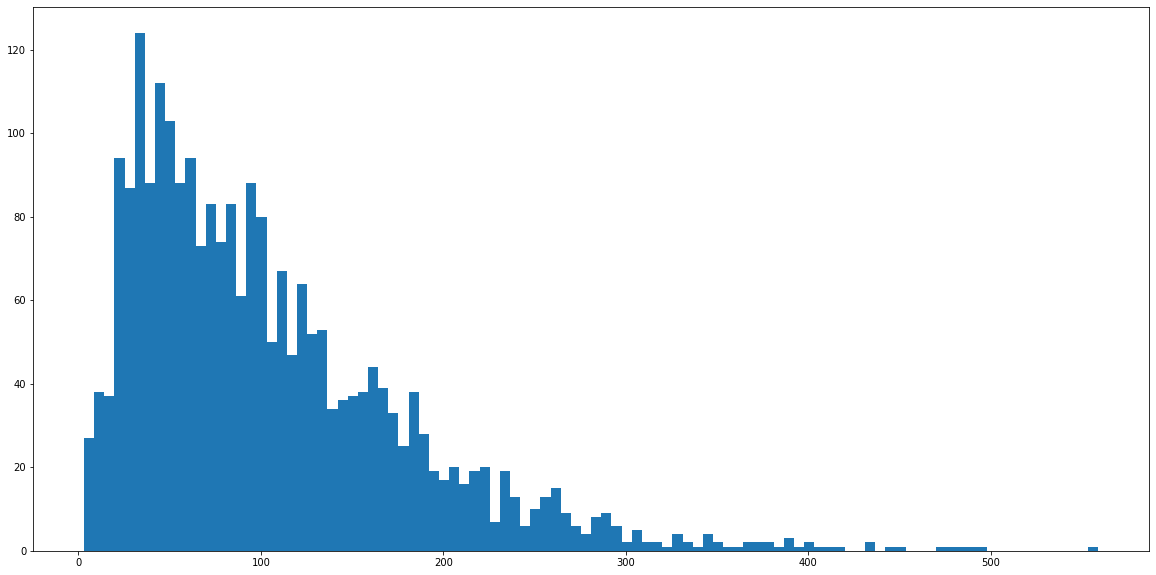

In [ ]:
# View distribution of sentence lengths

_ = plt.hist([len(x) for x in novel_sentences_ls], bins=100)

# **Clean and Slice Strings**

In [ ]:
def clean_str(dirty_str):
  '''
  INPUT: a raw string
  OUTPUT: a clean string
  '''

  contraction_expanded_str = contractions.fix(dirty_str)

  clean_str = clean(contraction_expanded_str,
      fix_unicode=True,               # fix various unicode errors
      to_ascii=True,                  # transliterate to closest ASCII representation
      lower=True,                     # lowercase text
      no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
      no_urls=False,                  # replace all URLs with a special token
      no_emails=False,                # replace all email addresses with a special token
      no_phone_numbers=False,         # replace all phone numbers with a special token
      no_numbers=False,               # replace all numbers with a special token
      no_digits=False,                # replace all digits with a special token
      no_currency_symbols=False,      # replace all currency symbols with a special token
      no_punct=False,                 # remove punctuations
      # replace_with_punct="",          # instead of removing punctuations you may replace them
      # replace_with_url="<URL>",
      # replace_with_email="<EMAIL>",
      # replace_with_phone_number="<PHONE>",
      # replace_with_number="<NUMBER>",
      # replace_with_digit="0",
      # replace_with_currency_symbol="<CUR>",
      lang="en"                       # set to 'de' for German special handling
  )

  # Replace all new lines/returns with single whitespace
  clean_str = ' '.join(clean_str.split())
  # clean_str = clean_str.replace('\n\r', ' ')
  # clean_str = clean_str.replace('\n', ' ')
  # clean_str = clean_str.replace('\r', ' ')
  # clean_str = ' '.join(clean_str.split())

  # Strip unpaired leading/trailing quotes
  if (clean_str.count('"') % 2 == 1):
    clean_str = clean_str.strip('"')
  if (clean_str.count("'") % 2 == 1):
    clean_str = clean_str.strip("'")

  return clean_str 

# Test

clean_str("This \n\n\n is a very dirty DIRTY StrInG!!")
clean_str('"up!')
clean_str('"Watch out!" he said.')

'this is a very dirty dirty string!!'

'up!'

'"watch out!" he said.'

In [ ]:
# Verify

# verify_novel(novel_clean_str, index_ends=500)

In [ ]:
# Create sentiment_df to hold text sentences and corresponding sentiment values

sentiment_df = pd.DataFrame({'text_raw': novel_sentences_ls})
sentiment_df['text_raw'] = sentiment_df['text_raw'].astype('string')
sentiment_df['text_raw'] = sentiment_df['text_raw'].str.strip()

sentiment_df.head()
sentiment_df.info()

,text_raw
0,"All children, except one, grow up."
1,"They soon know that they will grow up, and the..."
2,One day when she was two years old she was pla...
3,I suppose she must have looked rather delightf...
4,"Darling put her hand to her heart and cried, “..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2408 entries, 0 to 2407
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text_raw  2408 non-null   string
dtypes: string(1)
memory usage: 18.9 KB


In [ ]:
# clean the 'text_raw' column and create the 'text_clean' column

# novel_df['text_clean'] = hero.clean(novel_df['text_raw'])
sentiment_df['text_clean'] = sentiment_df['text_raw'].apply(lambda x: clean_str(x))
sentiment_df['text_clean'] = sentiment_df['text_clean'].astype('string')
sentiment_df['text_raw_len'] = sentiment_df['text_raw'].apply(lambda x: len(x))

sentiment_df.head()
sentiment_df.info()

,text_raw,text_clean,text_raw_len
0,"All children, except one, grow up.","all children, except one, grow up.",34
1,"They soon know that they will grow up, and the...","they soon know that they will grow up, and the...",71
2,One day when she was two years old she was pla...,one day when she was two years old she was pla...,125
3,I suppose she must have looked rather delightf...,i suppose she must have looked rather delightf...,58
4,"Darling put her hand to her heart and cried, “...","darling put her hand to her heart and cried, ""...",194


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2408 entries, 0 to 2407
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_raw      2408 non-null   string
 1   text_clean    2408 non-null   string
 2   text_raw_len  2408 non-null   int64 
dtypes: int64(1), string(2)
memory usage: 56.6 KB


In [ ]:
# Drop Sentence if Raw length < 1 (Double check)

# sentiment_df = sentiment_df[sentiment_df['text_raw_len'] > 0]

print(f"\n\nThere are {sentiment_df['text_raw'].isna().sum()} BLANK [text_raw] lines")

print(f"There are {sentiment_df['text_clean'].isna().sum()} BLANK [text_clean] lines")

sentiment_df.shape



There are 0 BLANK [text_raw] lines
There are 0 BLANK [text_clean] lines


(2408, 3)

In [ ]:
sentiment_df.sort_values(by=['text_raw_len']).head(20)

,text_raw,text_clean,text_raw_len
319,No.,no.,3
26,Mr.,mr.,3
537,Mr.,mr.,3
16,Mr.,mr.,3
286,Mr.,mr.,3
36,Mrs.,mrs.,4
97,Mrs.,mrs.,4
1414,“Me!,me!,4
65,Mrs.,mrs.,4
114,Mrs.,mrs.,4


# **Sentiment Analysis**

## **VADER**

In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 8.0 MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader_sa = SentimentIntensityAnalyzer()

In [ ]:
vader_sa.polarity_scores('I love lint')['compound']

0.6369

In [ ]:
sentiment_df['vader'] = sentiment_df['text_clean'].apply(lambda x : vader_sa.polarity_scores(x)['compound'])
sentiment_df.head(10)

,text_raw,text_clean,text_raw_len,vader
0,"All children, except one, grow up.","all children, except one, grow up.",34,0.0000
1,"They soon know that they will grow up, and the...","they soon know that they will grow up, and the...",71,0.0000
2,One day when she was two years old she was pla...,one day when she was two years old she was pla...,125,0.2023
3,I suppose she must have looked rather delightf...,i suppose she must have looked rather delightf...,58,0.5859
4,"Darling put her hand to her heart and cried, “...","darling put her hand to her heart and cried, ""...",194,0.6171
5,You always know after you are two.,you always know after you are two.,34,0.0000
6,Two is the beginning of the end.,two is the beginning of the end.,32,0.0000
7,"Of course they lived at 14, and until Wendy ca...","of course they lived at 14, and until wendy ca...",78,0.0000
8,"She was a lovely lady, with a romantic mind an...","she was a lovely lady, with a romantic mind an...",75,0.7783
9,"Her romantic mind was like the tiny boxes, one...","her romantic mind was like the tiny boxes, one...",294,0.9147


## **TextBlob**

In [ ]:
from textblob import TextBlob

In [ ]:
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
print(testimonial.sentiment.polarity)

0.39166666666666666


In [ ]:
sentiment_df['textblob'] = sentiment_df['text_clean'].apply(lambda x : TextBlob(x).sentiment.polarity)
sentiment_df.head(10)

,text_raw,text_clean,text_raw_len,vader,textblob
0,"All children, except one, grow up.","all children, except one, grow up.",34,0.0000,0.000000
1,"They soon know that they will grow up, and the...","they soon know that they will grow up, and the...",71,0.0000,0.000000
2,One day when she was two years old she was pla...,one day when she was two years old she was pla...,125,0.2023,0.100000
3,I suppose she must have looked rather delightf...,i suppose she must have looked rather delightf...,58,0.5859,1.000000
4,"Darling put her hand to her heart and cried, “...","darling put her hand to her heart and cried, ""...",194,0.6171,-0.166667
5,You always know after you are two.,you always know after you are two.,34,0.0000,0.000000
6,Two is the beginning of the end.,two is the beginning of the end.,32,0.0000,0.000000
7,"Of course they lived at 14, and until Wendy ca...","of course they lived at 14, and until wendy ca...",78,0.0000,0.000000
8,"She was a lovely lady, with a romantic mind an...","she was a lovely lady, with a romantic mind an...",75,0.7783,0.212500
9,"Her romantic mind was like the tiny boxes, one...","her romantic mind was like the tiny boxes, one...",294,0.9147,0.317857


# **Plot Sentiment**

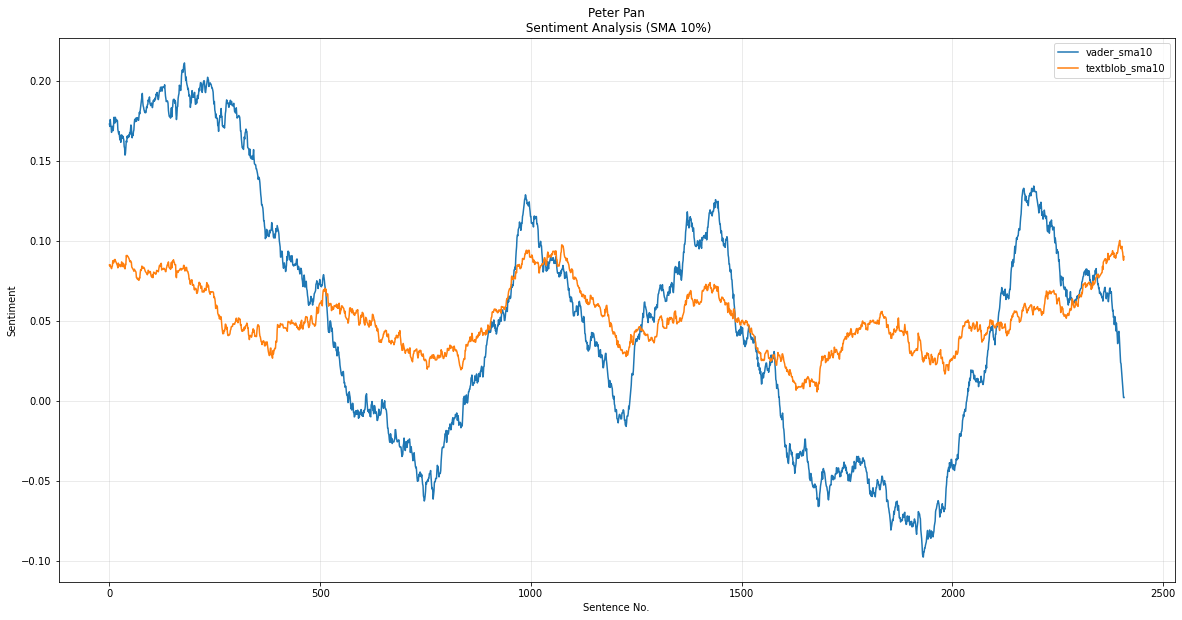

In [ ]:
#@title Enter the Sliding Window width as Percent of Novel length (default 10%, larger=smoother)

window_percent = 10 #@param {type:"slider", min:1, max:20, step:1}

win_per = int(window_percent/100 * sentiment_df.shape[0])

vader_col = f'vader_sma{window_percent}'
sentiment_df[vader_col] = sentiment_df['vader'].rolling(win_per, center=True, min_periods=1).mean()

textblob_col = f'textblob_sma{window_percent}'
sentiment_df[textblob_col] = sentiment_df['textblob'].rolling(win_per, center=True, min_periods=1).mean()
sentiment_df.plot(y=[vader_col, textblob_col])

plt.title(f'{Novel_Title}\n Sentiment Analysis (SMA {window_percent}%)')
plt.ylabel('Sentiment')
plt.xlabel('Sentence No.')
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.show();

In [ ]:
sentiment_df.head()

,text_raw,text_clean,text_raw_len,vader,textblob,vader_sma10,textblob_sma10
0,"All children, except one, grow up.","all children, except one, grow up.",34,0.0000,0.000000,0.173247,0.085020
1,"They soon know that they will grow up, and the...","they soon know that they will grow up, and the...",71,0.0000,0.000000,0.171815,0.084317
2,One day when she was two years old she was pla...,one day when she was two years old she was pla...,125,0.2023,0.100000,0.176106,0.085142
3,I suppose she must have looked rather delightf...,i suppose she must have looked rather delightf...,58,0.5859,1.000000,0.173029,0.084043
4,"Darling put her hand to her heart and cried, “...","darling put her hand to her heart and cried, ""...",194,0.6171,-0.166667,0.171634,0.083366


# **Crux Detection**

In [ ]:
#@title Which Lexicon?

Sentiment_Model = "VADER" #@param ["VADER", "TextBlob"]

<ipython-input-45-1093e5ba1886>:29: PeakPropertyWarning: some peaks have a width of 0
  peaks3, _ = find_peaks(x, width=width_min)


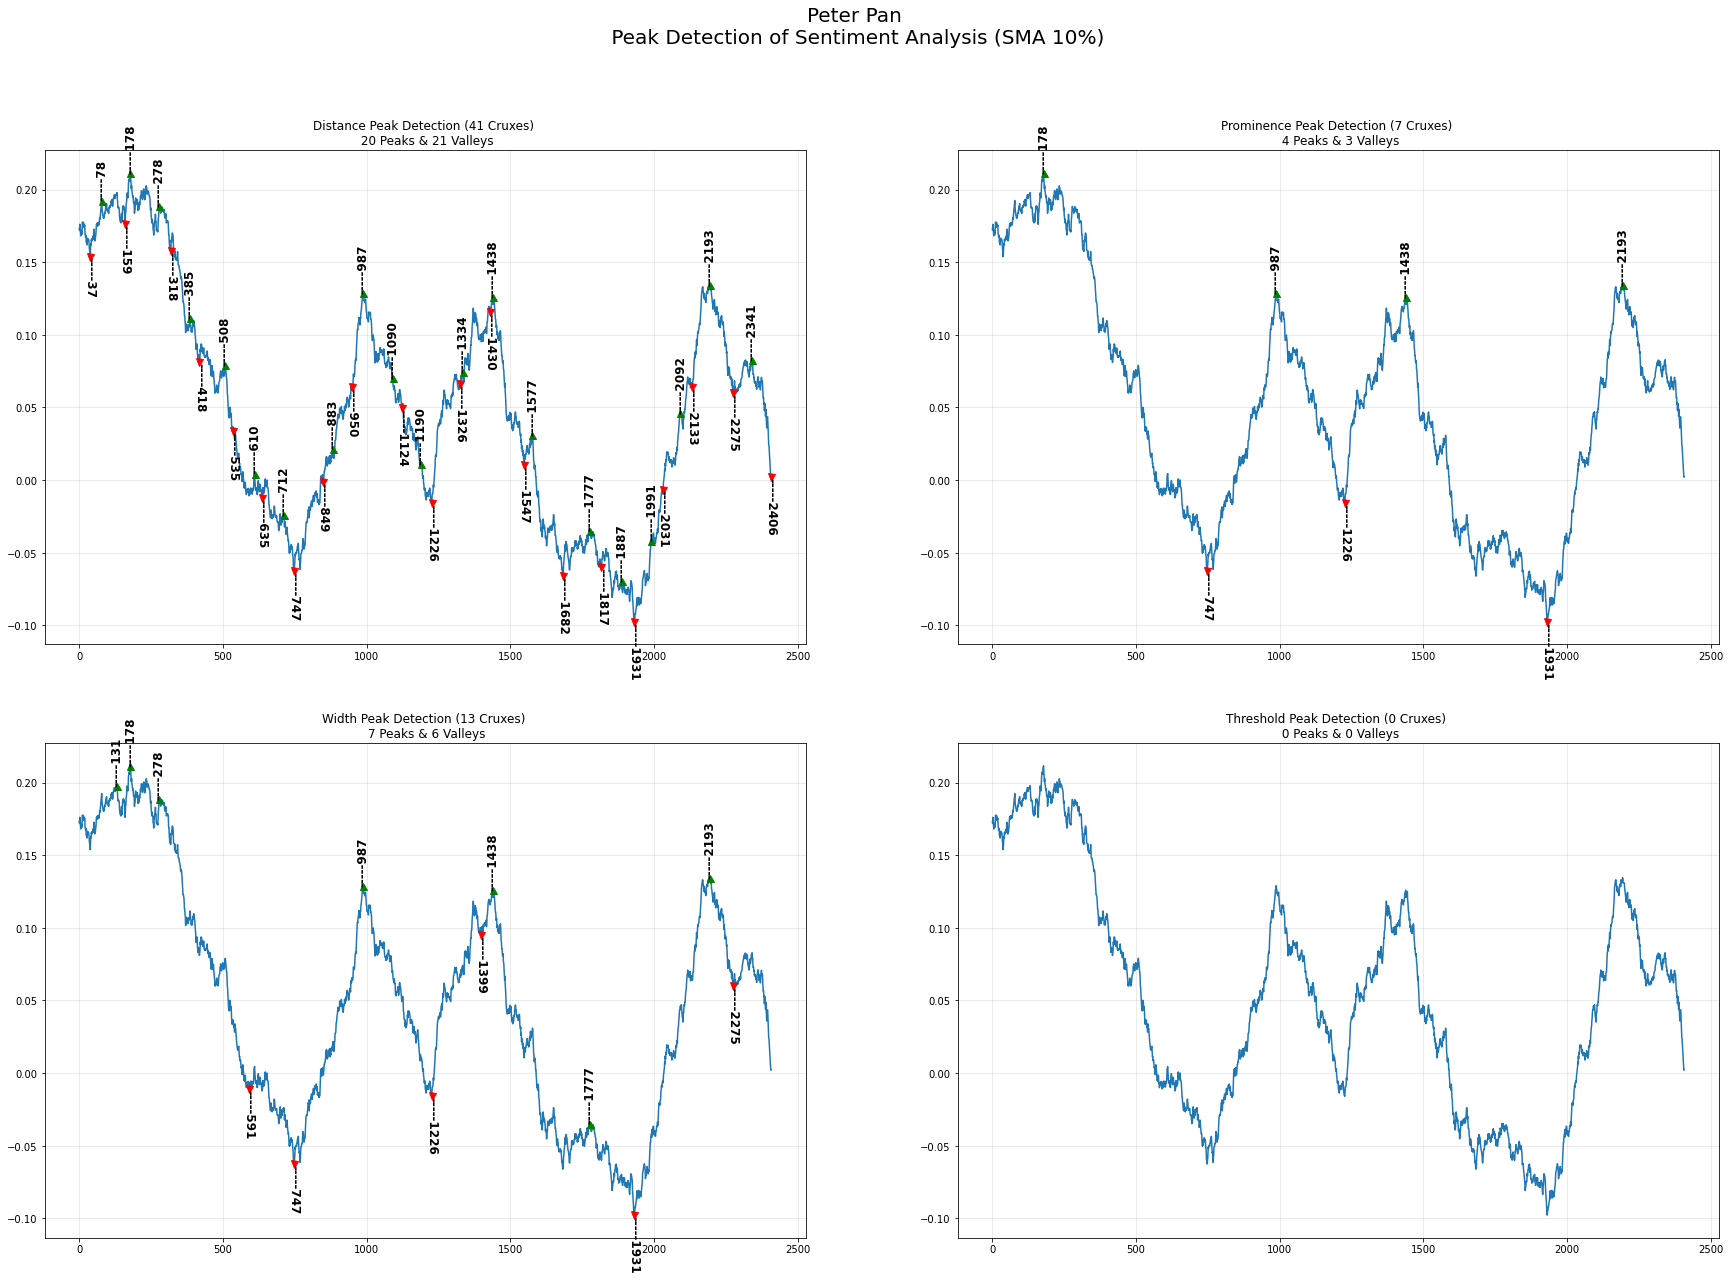

In [ ]:
#@title Tune the main Hyperparameter for each of the 4 Peak Detection Algorithms:

Distance_Min = 100 #@param {type:"slider", min:100, max:1000, step:10}
Prominence_Min = 0.041 #@param {type:"slider", min:0.001, max:0.05, step:0.001}
Width_Min = 25 #@param {type:"slider", min:25, max:500, step:5}
Threshold_Min = 0.009 #@param {type:"slider", min:0.001, max:0.01, step:0.001}

plt.rcParams['figure.figsize'] = [30, 20]

model_name = f'{Sentiment_Model.lower()}_sma{window_percent}'

x = sentiment_df[model_name]

# Peak Algo #1 (by Distance)
distance_min = Distance_Min # 750

# Peak Algo #2 (by Prominence)
prominence_min = Prominence_Min # 0.01

# Peak Algo #3 (by Width)
width_min = Width_Min # 175

# Peak Algo #4 (by Threshold)
threshold_min = Threshold_Min # 0.001


peaks, _ = find_peaks(x, distance=distance_min)
peaks2, _ = find_peaks(x, prominence=prominence_min)      # BEST!
peaks3, _ = find_peaks(x, width=width_min)
peaks4, _ = find_peaks(x, threshold=threshold_min)     # Required vertical distance to its direct neighbouring samples, pretty useless


x_inv = pd.Series([-x for x in sentiment_df[model_name].to_list()])

valleys, _ = find_peaks(x_inv, distance=distance_min)
valleys2, _ = find_peaks(x_inv, prominence=prominence_min)      # BEST!
valleys3, _ = find_peaks(x_inv, width=width_min)
valleys4, _ = find_peaks(x_inv, threshold=threshold_min)     # Required vertical distance to its direct neighbouring samples, pretty useless


_ = plt.subplot(2, 2, 1)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Distance Peak Detection ({len(peaks)+len(valleys)} Cruxes) \n {len(peaks)} Peaks & {len(valleys)} Valleys')
_ = plt.plot(peaks, x[peaks], "^g", markersize=7)
_ = plt.plot(valleys, x[valleys], "vr", markersize=7)
for x_val in peaks:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')

_ = plt.subplot(2, 2, 2)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Prominence Peak Detection ({len(peaks2)+len(valleys2)} Cruxes) \n {len(peaks2)} Peaks & {len(valleys2)} Valleys')
_ = plt.plot(peaks2, x[peaks2], "^g", markersize=7)
_ = plt.plot(valleys2, x[valleys2], "vr", markersize=7)
for x_val in peaks2:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys2:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')


_ = plt.subplot(2, 2, 3)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Width Peak Detection ({len(peaks3)+len(valleys3)} Cruxes) \n {len(peaks3)} Peaks & {len(valleys3)} Valleys')
_ = plt.plot(valleys3, x[valleys3], "vr", markersize=7)
_ = plt.plot(peaks3, x[peaks3], "^g", markersize=7)
for x_val in peaks3:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys3:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')


_ = plt.subplot(2, 2, 4)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Threshold Peak Detection ({len(peaks4)+len(valleys4)} Cruxes) \n {len(peaks4)} Peaks & {len(valleys4)} Valleys')
_ = plt.plot(valleys4, x[valleys4], "vr", markersize=7)
_ = plt.plot(valleys4, x[valleys4], "^g", markersize=7)
for x_val in peaks4:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys4:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')

_ = plt.suptitle(f'{Novel_Title}\n Peak Detection of Sentiment Analysis (SMA {window_percent}%)', fontsize=20)
_ = plt.grid(True, alpha=0.3)

_ = plt.show()

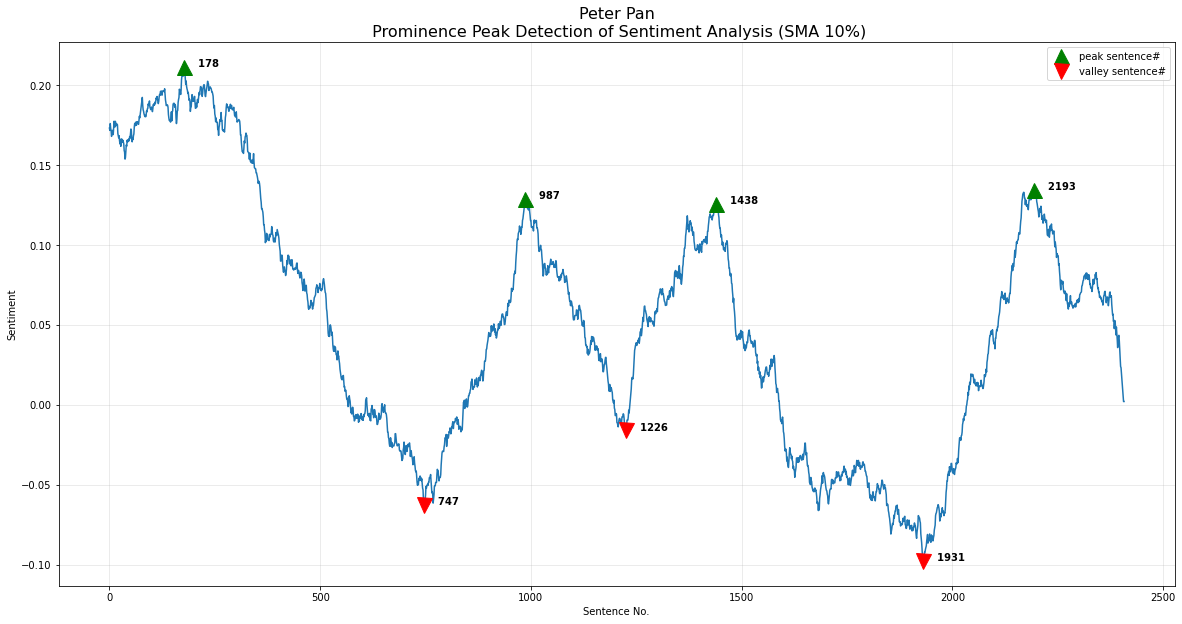



     >>>>> SAVED PLOT TO FILE: [cruxes_plot_Peter_Pan.png] <<<<<


In [ ]:
#@title Select a Peak Detection Algorithms to View in Detail (usually Distance or Width is best):

plt.rcParams['figure.figsize'] = [20, 10]

Peak_Algorithm = "Prominence" #@param ["Distance", "Prominence", "Width", "Threshold"]

if Peak_Algorithm == 'Distance':
  peaks = peaks
  valleys = valleys
elif Peak_Algorithm == 'Prominence':
  peaks = peaks2
  valleys = valleys2  
elif Peak_Algorithm == 'Width':
  peaks = peaks3
  valleys = valleys3
else:
  # Assume Peak_Algorithm == 'Threshold'
  peaks = peaks4
  valleys = valleys4

# model_name = f'{Sentiment_Model.lower()}_sma10'

# x = novel_clean_df[model_name]

# peaks2, _ = find_peaks(x, prominence=peak_prominence)  

# x_inv = pd.Series([-x for x in novel_clean_df[model_name].to_list()])
# valleys2, _ = find_peaks(x_inv, prominence=peak_prominence)     

_ = plt.plot(x)
_ = plt.plot(peaks, x[peaks], "^g", markersize=15, label='peak sentence#')
_ = plt.plot(valleys, x[valleys], "vr", markersize=15, label='valley sentence#')
for x_val in peaks:
  _ = plt.text(x_val, x[x_val], f'    {x_val}', horizontalalignment='left', size='medium', color='black', weight='semibold')
for x_val in valleys:
  _ = plt.text(x_val, x[x_val], f'    {x_val}', horizontalalignment='left', size='medium', color='black', weight='semibold')
_ = plt.title(f'{Novel_Title}\n {Peak_Algorithm} Peak Detection of Sentiment Analysis (SMA {window_percent}%)', fontsize=16)
_ = plt.ylabel('Sentiment')
_ = plt.xlabel('Sentence No.')
_ = plt.legend(loc='best')
_ = plt.grid(True, alpha=0.3)

filename_plot = f"cruxes_plot_{Novel_Title.replace(' ', '_')}.png"
_ = plt.savefig(filename_plot, dpi=300)
_ = plt.show();

print(f'\n\n     >>>>> SAVED PLOT TO FILE: [{filename_plot}] <<<<<')

In [ ]:
# Download Crux Point Plot file 'crux_plot.png' to your laptop

files.download(filename_plot)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Get Context around Crux Points**

In [ ]:
#@title How many Sentences around Crux Point do you want to view for context?

Crux_Sentence_Context_Count = 19 #@param {type:"slider", min:1, max:20, step:1}


In [ ]:
# Print Context around each Sentiment Peak

output_ls = []

halfwin = int(Crux_Sentence_Context_Count/2)
crux_sents_ls = []
nl = '\n'

print('==================================================')
print('============     Peak Crux Points   ==============')
print('==================================================\n\n')

output_ls.append('==================================================')
output_ls.append('============     Peak Crux Points   ==============')
output_ls.append('==================================================\n\n')

# for i, apeak in enumerate(peaks2):
for i, apeak in enumerate(peaks):
  print(f'Processing Peak #{i}...')
  crux_sents_ls = []
  for sent_idx in range(apeak-halfwin,apeak+halfwin+1):
    sent_cur = sentiment_df.iloc[sent_idx].text_raw
    if sent_idx == apeak:
      sent_str = sent_cur.upper()
    else:
      sent_str = sent_cur
    crux_sents_ls.append(sent_str)
  
  # context_ls = sentiment_df.iloc[apeak-halfwin:apeak+halfwin].text_raw
  print(f"Peak #{i} at Sentence #{apeak}:\n\n{nl.join(crux_sents_ls)}\n\n\n")
  output_ls.append(f"Peak #{i} at Sentence #{apeak}:\n\n{nl.join(crux_sents_ls)}\n\n\n")

print('==================================================')
print('===========     Crux Valley Points    ============')
print('==================================================\n\n')

output_ls.append('==================================================')
output_ls.append('===========     Crux Valley Points    ============')
output_ls.append('==================================================\n\n')

# for i, avalley in enumerate(valleys2):
for i, avalley in enumerate(valleys):
  print(f'Processing Valley #{i}')
  crux_sents_ls = []
  for sent_idx in range(avalley-halfwin,avalley+halfwin+1):
    sent_cur = sentiment_df.iloc[sent_idx].text_raw
    if sent_idx == avalley:
      sent_str = sent_cur.upper()
    else:
      sent_str = sent_cur
    crux_sents_ls.append(sent_str)

  # context_ls = novel_df.iloc[avalley-halfwin:avalley+halfwin].text_raw
  print(f"Valley #{i} at Sentence #{avalley}:\n\n{nl.join(crux_sents_ls)}\n\n\n")
  output_ls.append(f"Valley #{i} at Sentence #{avalley}:\n\n{nl.join(crux_sents_ls)}\n\n\n")

filename_cruxes = f"cruxes_context_{Novel_Title.replace(' ', '_')}.txt" 

output_str = ' '.join(output_ls)

with open(filename_cruxes, 'w') as f:
    f.write(output_str)

============     Peak Crux Points   ==============


Processing Peak #0...
Peak #0 at Sentence #178:

Darling always said, “I am responsible for it all.
I, George Darling, did it.
Mea culpa, mea culpa.” He had had a classical education.
They sat thus night after night recalling that fatal Friday, till every detail of it was stamped on their brains and came through on the other side like the faces on a bad coinage.
“If only I had not accepted that invitation to dine at 27,” Mrs.
Darling said.
“If only I had not poured my medicine into Nana’s bowl,” said Mr.
Darling.
“If only I had pretended to like the medicine,” was what Nana’s wet eyes said.
“MY LIKING FOR PARTIES, GEORGE.” 

 “MY FATAL GIFT OF HUMOUR, DEAREST.” 

 “MY TOUCHINESS ABOUT TRIFLES, DEAR MASTER AND MISTRESS.” 

 THEN ONE OR MORE OF THEM WOULD BREAK DOWN ALTOGETHER; NANA AT THE THOUGHT, “IT’S TRUE, IT’S TRUE, THEY OUGHT NOT TO HAVE HAD A DOG FOR A NURSE.” MANY A TIME IT WAS MR.
Darling who put the handkerchief to Nana’s eye

11979

In [ ]:
# Download Crux Point Report file 'cruxes.txt' to your laptop

files.download(filename_cruxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cat $filename_cruxes

================================================== ============     Peak Crux Points   ============== ==================================================

 Peak #0 at Sentence #178:

Darling always said, “I am responsible for it all.
I, George Darling, did it.
Mea culpa, mea culpa.” He had had a classical education.
They sat thus night after night recalling that fatal Friday, till every detail of it was stamped on their brains and came through on the other side like the faces on a bad coinage.
“If only I had not accepted that invitation to dine at 27,” Mrs.
Darling said.
“If only I had not poured my medicine into Nana’s bowl,” said Mr.
Darling.
“If only I had pretended to like the medicine,” was what Nana’s wet eyes said.
“MY LIKING FOR PARTIES, GEORGE.” 

 “MY FATAL GIFT OF HUMOUR, DEAREST.” 

 “MY TOUCHINESS ABOUT TRIFLES, DEAR MASTER AND MISTRESS.” 

 THEN ONE OR MORE OF THEM WOULD BREAK DOWN ALTOGETHER; NANA AT THE THOUGHT, “IT’S TRUE, IT’S TRUE, THEY OUGHT NOT TO HAVE HAD A DOG FOR

# **END OF NOTEBOOK**